[*********************100%***********************]  1 of 1 completed


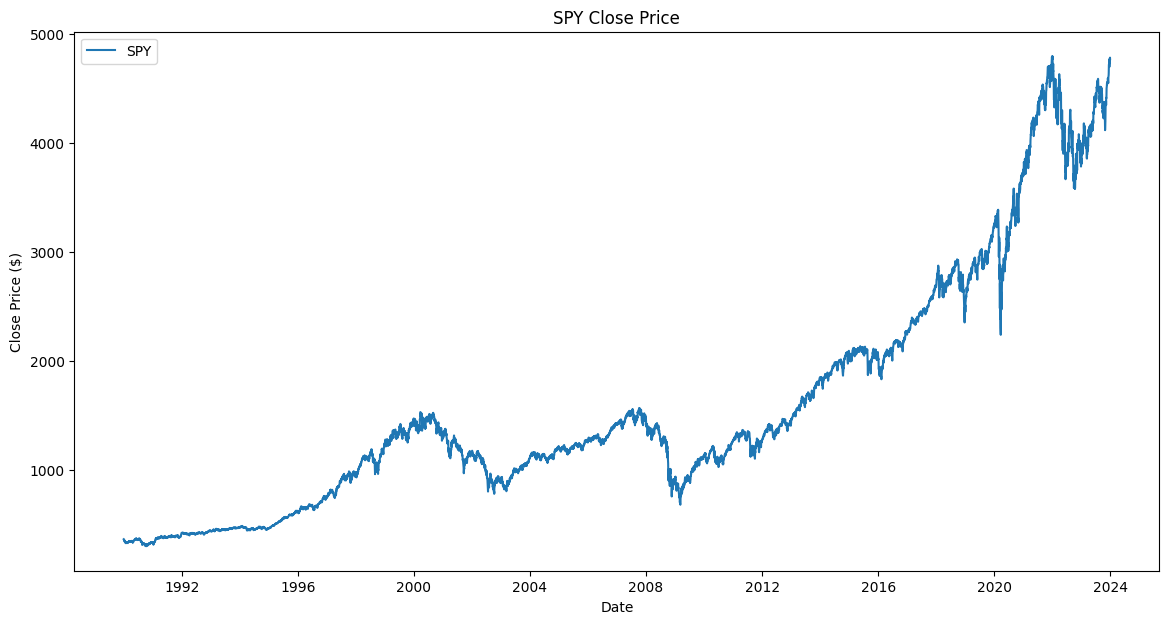

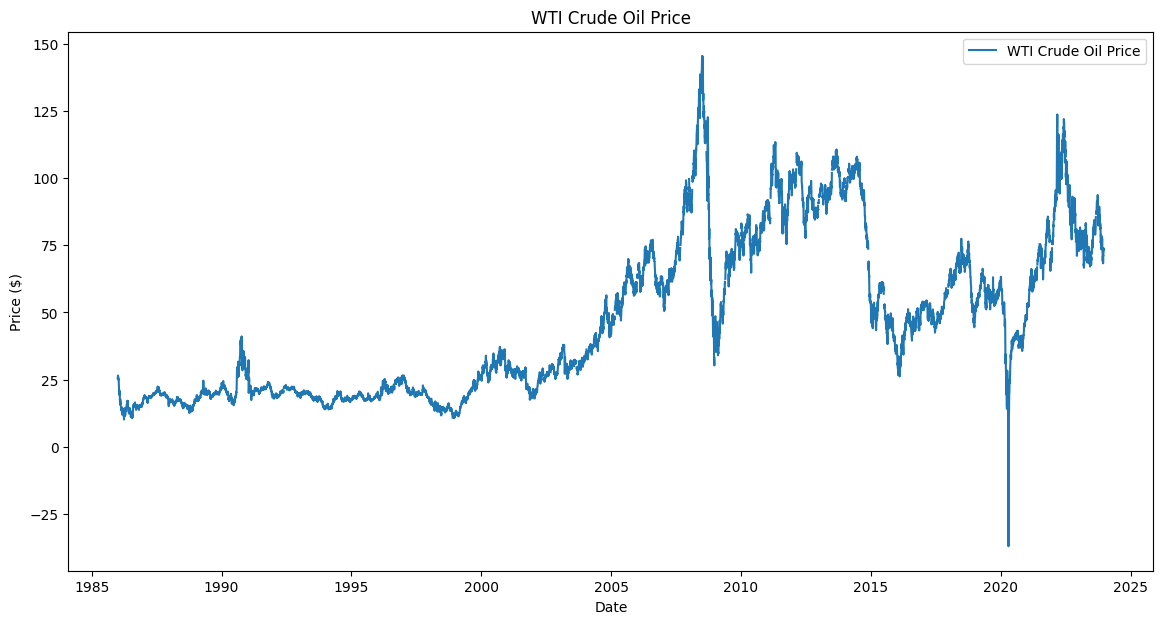

C:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


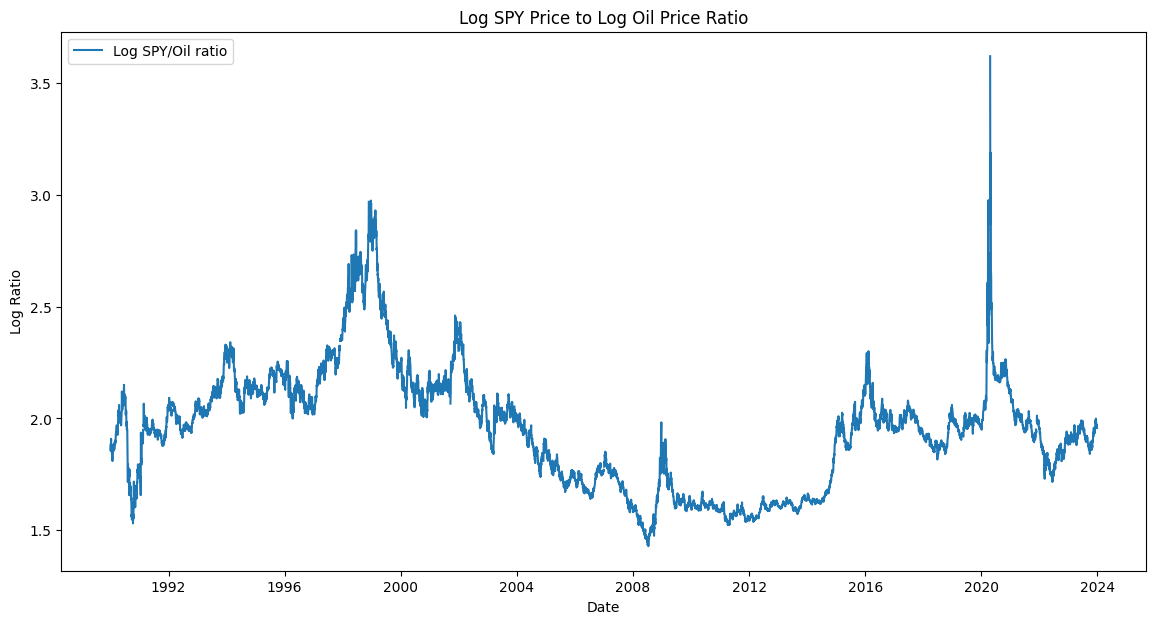

Intercept: -12.902907368969524
Slope: 2.006950858737879e-05


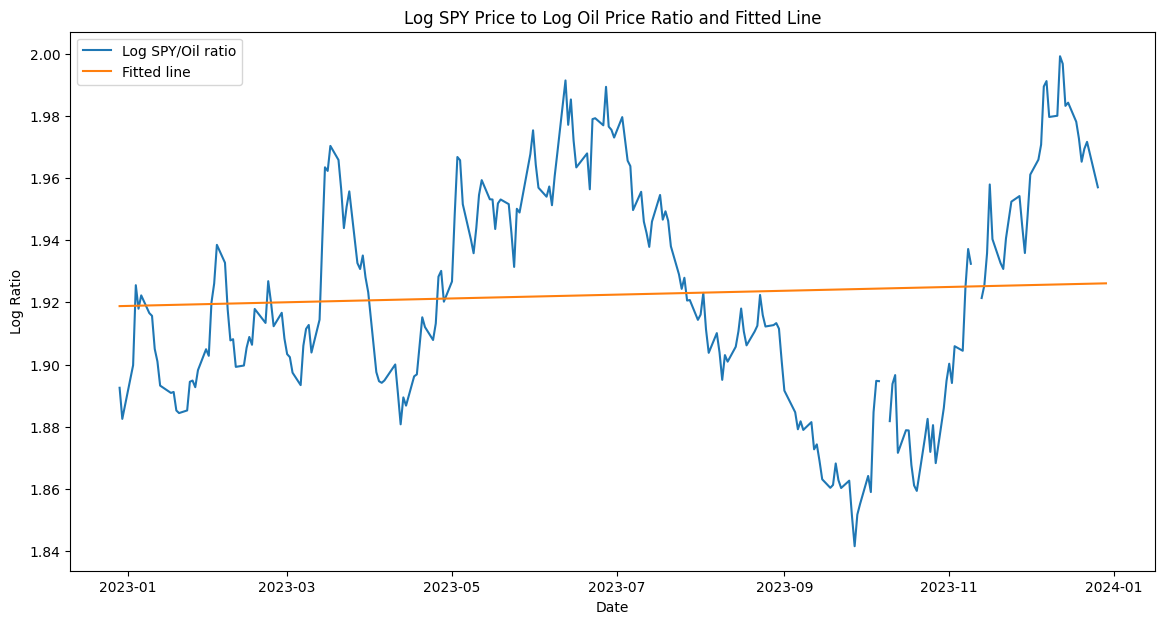

Intercept: 24.77135967556247
Slope: -3.0901941301452855e-05


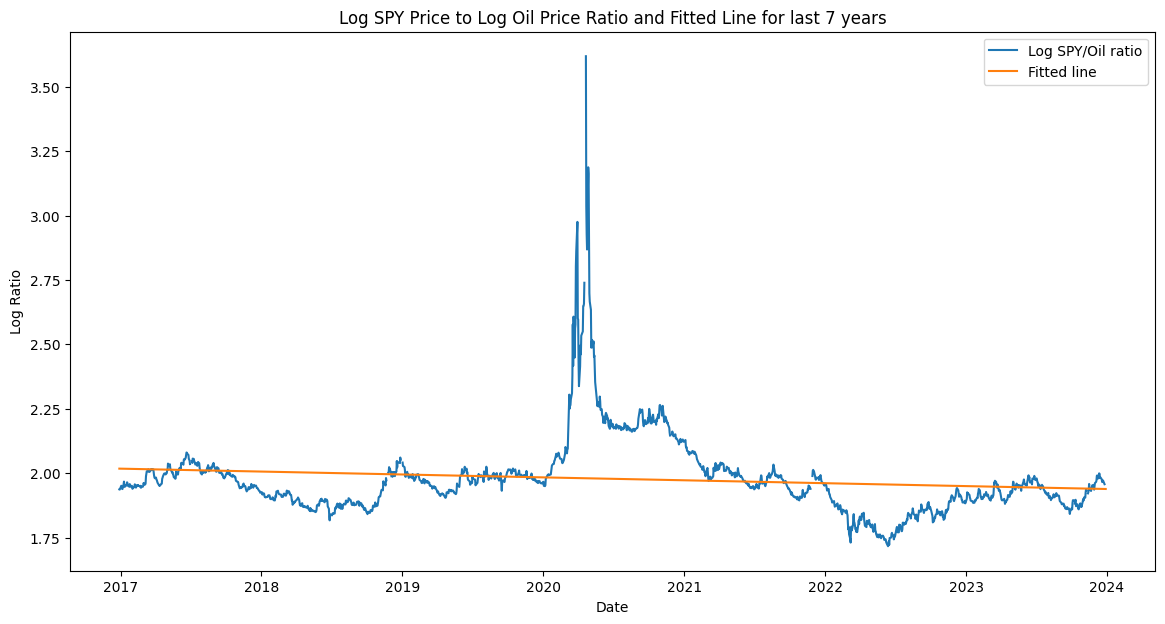

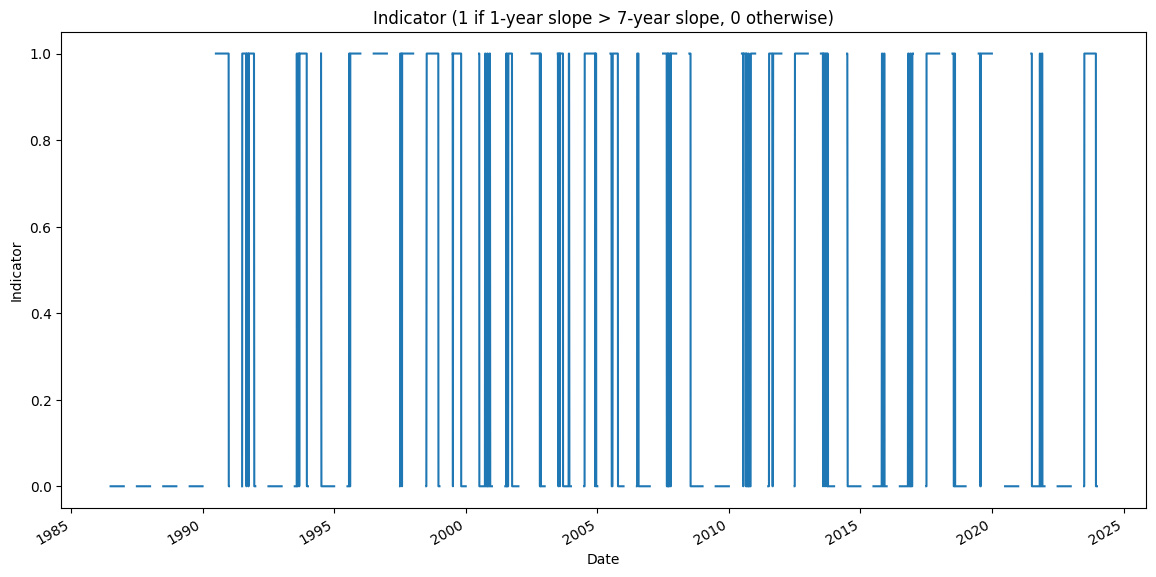

Latest Indicator Value:  0.0


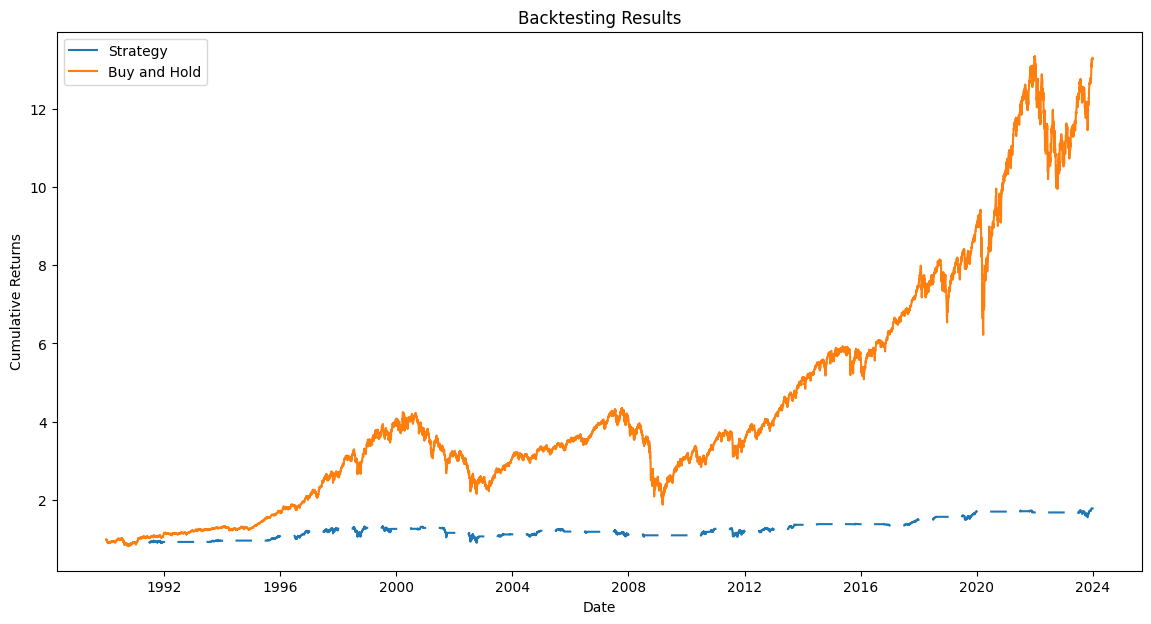

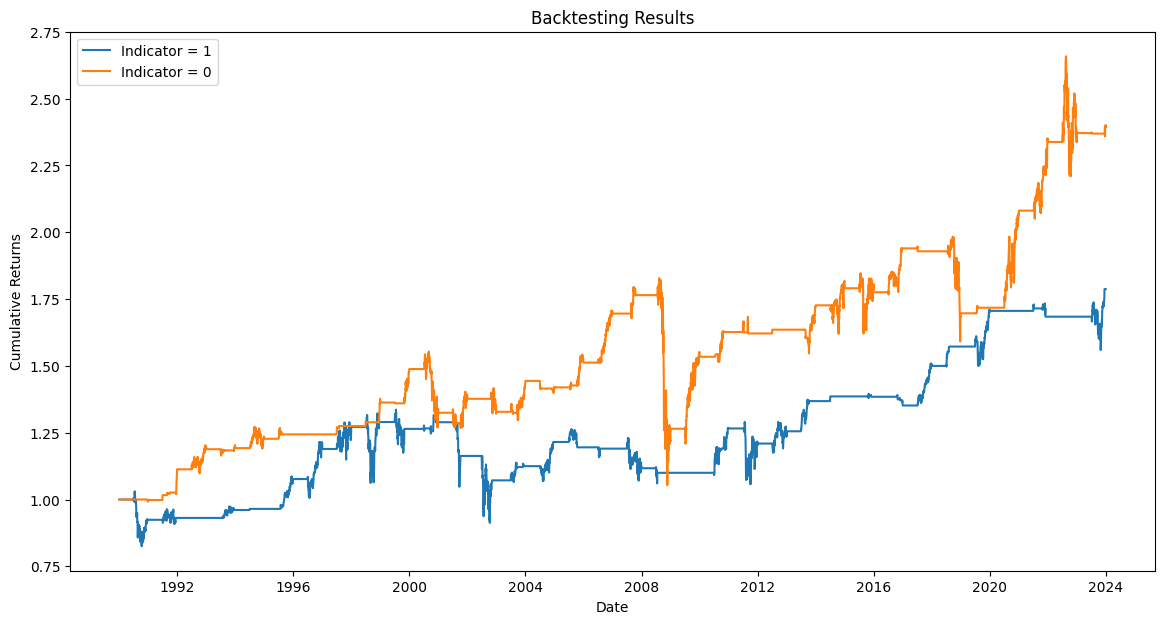

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
import numpy as np
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression


# Fetch SPY data
spy = yf.download('^GSPC', start='1990-01-01')
spy_close = spy['Close']

# Plot SPY data
plt.figure(figsize=(14, 7))
plt.plot(spy_close.index, spy_close, label='SPY')
plt.title('SPY Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()

# Replace 'my_api_key' with your actual FRED API key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch WTI Crude Oil Price data
oil_price = fred.get_series('DCOILWTICO')

# Plot oil price data
plt.figure(figsize=(14, 7))
plt.plot(oil_price.index, oil_price, label='WTI Crude Oil Price')
plt.title('WTI Crude Oil Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


# Remove or fill in missing values
spy_close = spy_close.dropna()
oil_price = oil_price.dropna()

# Replace zero values (if any exist)
spy_close = spy_close.replace(0, np.nan)
oil_price = oil_price.replace(0, np.nan)

# Calculate the logarithms
spy_log = np.log(spy_close)
oil_log = np.log(oil_price)

# Remove any new NaN values that might have been created
spy_log = spy_log.dropna()
oil_log = oil_log.dropna()

spy_oil_log_ratio = (spy_log / oil_log)


# Plot the log price ratio
plt.figure(figsize=(14, 7))
plt.plot(spy_oil_log_ratio.index, spy_oil_log_ratio, label='Log SPY/Oil ratio')
plt.title('Log SPY Price to Log Oil Price Ratio')
plt.xlabel('Date')
plt.ylabel('Log Ratio')
plt.legend()
plt.show()

# Calculate the latest date
latest_date = max(spy_oil_log_ratio.index)

# Get the last year of ratio data
one_year_ago = pd.Timestamp(latest_date) - DateOffset(years=1)
last_year_log_ratio = spy_oil_log_ratio[spy_oil_log_ratio.index >= one_year_ago]

# Define a function to convert date to ordinal
def convert_date_to_ordinal(date):
    return date.toordinal()

# Convert index to a numeric format for regression
X = np.array(last_year_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
y = last_year_log_ratio.values


# Handle missing values in y by filling them in with the mean value
y = pd.Series(y).fillna(pd.Series(y).mean()).values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Print out the coefficients
print('Intercept:', model.intercept_)
print('Slope:', model.coef_[0])

# Plot the data and the fitted line
plt.figure(figsize=(14, 7))
plt.plot(last_year_log_ratio.index, last_year_log_ratio.values, label='Log SPY/Oil ratio')
plt.plot(last_year_log_ratio.index, model.predict(X), label='Fitted line')
plt.title('Log SPY Price to Log Oil Price Ratio and Fitted Line')
plt.xlabel('Date')
plt.ylabel('Log Ratio')
plt.legend()
plt.show()


# Get the last 7 years of ratio data
seven_years_ago = pd.Timestamp(latest_date) - DateOffset(years=7)
last_seven_years_log_ratio = spy_oil_log_ratio[spy_oil_log_ratio.index >= seven_years_ago]

# Convert index to a numeric format for regression
X = np.array(last_seven_years_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
y = last_seven_years_log_ratio.values

# Handle missing values in y by filling them in with the mean value
y = pd.Series(y).fillna(pd.Series(y).mean()).values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Print out the coefficients
print('Intercept:', model.intercept_)
print('Slope:', model.coef_[0])

# Plot the data and the fitted line
plt.figure(figsize=(14, 7))
plt.plot(last_seven_years_log_ratio.index, last_seven_years_log_ratio.values, label='Log SPY/Oil ratio')
plt.plot(last_seven_years_log_ratio.index, model.predict(X), label='Fitted line')
plt.title('Log SPY Price to Log Oil Price Ratio and Fitted Line for last 7 years')
plt.xlabel('Date')
plt.ylabel('Log Ratio')
plt.legend()
plt.show()



def calculate_slope(X, y):
    """Fit a linear regression model and return the slope"""
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

# Initialize the indicator series
indicator = pd.Series(index=spy_oil_log_ratio.index)

# Compute the 1-year and 7-year slopes for each day
for date in spy_oil_log_ratio.index:
    # Compute the 1-year slope
    one_year_ago = date - DateOffset(month=3)
    last_year_log_ratio = spy_oil_log_ratio[(spy_oil_log_ratio.index >= one_year_ago) & (spy_oil_log_ratio.index < date)]
    if not last_year_log_ratio.empty:
        X1 = np.array(last_year_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_log_ratio.values
        if pd.Series(y1).isna().all():
            y1 = pd.Series(y1).fillna(0).values  # or use another default value
        else:
            y1 = pd.Series(y1).fillna(pd.Series(y1).mean()).values
        one_year_slope = calculate_slope(X1, y1)
        
            # Compute the 7-year slope
        seven_years_ago = date - DateOffset(month=6)
        last_seven_years_log_ratio = spy_oil_log_ratio[(spy_oil_log_ratio.index >= seven_years_ago) & (spy_oil_log_ratio.index < date)]
        if not last_seven_years_log_ratio.empty:
            X7 = np.array(last_seven_years_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
            y7 = last_seven_years_log_ratio.values
            if pd.Series(y7).isna().all():  # Use y7 here instead of y1
                y7 = pd.Series(y7).fillna(0).values  # or use another default value
            else:
                y7 = pd.Series(y7).fillna(pd.Series(y7).mean()).values  # Use y7 here instead of y1
            seven_years_slope = calculate_slope(X7, y7)

            # Set the indicator
            indicator[date] = int(one_year_slope > seven_years_slope)

# Plot the indicator
plt.figure(figsize=(14, 7))
indicator.plot()
plt.title('Indicator (1 if 1-year slope > 7-year slope, 0 otherwise)')
plt.xlabel('Date')
plt.ylabel('Indicator')
plt.show()

# Print the latest indicator value
latest_indicator_value = indicator.iloc[-1]
print("Latest Indicator Value: ", latest_indicator_value)

# Add the backtesting code after the previous script

# Combine the SPY closing prices and the indicator into one DataFrame
spy_close = spy_close.reindex(spy_oil_log_ratio.index)
backtest_data = pd.DataFrame({'spy_close': spy_close, 'indicator': indicator})

# Forward fill missing values in the SPY closing prices
backtest_data['spy_close'].fillna(method='ffill', inplace=True)

# Calculate the daily returns
backtest_data['daily_returns'] = backtest_data['spy_close'].pct_change() * backtest_data['indicator']

# Calculate the cumulative returns
backtest_data['cumulative_returns'] = (1 + backtest_data['daily_returns']).cumprod()

# Calculate the cumulative returns for buy and hold strategy for comparison
backtest_data['buy_and_hold_returns'] = (1 + backtest_data['spy_close'].pct_change()).cumprod()

# Plot the backtesting results
plt.figure(figsize=(14, 7))
plt.plot(backtest_data['cumulative_returns'], label='Strategy')
plt.plot(backtest_data['buy_and_hold_returns'], label='Buy and Hold')
plt.title('Backtesting Results')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


# Combine the SPY closing prices and the indicator into one DataFrame
spy_close = spy_close.reindex(spy_oil_log_ratio.index)
backtest_data = pd.DataFrame({'spy_close': spy_close, 'indicator': indicator})

# Forward fill missing values in the SPY closing prices
backtest_data['spy_close'].fillna(method='ffill', inplace=True)

# Calculate the daily returns
backtest_data['daily_returns'] = backtest_data['spy_close'].pct_change()

# Calculate the cumulative returns when indicator is 1 and 0
backtest_data['cumulative_returns_1'] = (1 + backtest_data['daily_returns'] * (backtest_data['indicator'] == 1)).cumprod()
backtest_data['cumulative_returns_0'] = (1 + backtest_data['daily_returns'] * (backtest_data['indicator'] == 0)).cumprod()

# Plot the backtesting results
plt.figure(figsize=(14, 7))
plt.plot(backtest_data['cumulative_returns_1'], label='Indicator = 1')
plt.plot(backtest_data['cumulative_returns_0'], label='Indicator = 0')
plt.title('Backtesting Results')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()